In [41]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [42]:
df = pd.read_csv('Data/BC/forecast1972-2023.csv')


In [43]:
# # Ensure 'Year' and 'Flow' are numeric, 'SYM' is categorical
# df['SYM'].fillna('Unknown', inplace=True)

# df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
# df['Flow'] = pd.to_numeric(df['Flow'], errors='coerce')
# df['SYM'] = df['SYM'].astype('category')

# # Plot
# plt.figure(figsize=(12, 6))
# sns.scatterplot(data=df, x='Month', y='Flow', hue='SYM', palette='viridis', alpha=0.7)

# plt.xlabel('Month')
# plt.ylabel('Flow')
# plt.title('Flow vs. Month with SYM as Color')
# plt.legend(title='SYM')
# plt.grid(True)
# plt.show()

In [44]:
# Drop any non-numeric columns that aren't needed for training
df.drop(['LOCAL_DATE', 'SYM', 'DIRECTION_MAX_GUST1', 'SPEED_MAX_GUST1',	'SNOW_ON_GROUND1',	'TOTAL_PRECIPITATION1',	'HEATING_DEGREE_DAYS1',	'COOLING_DEGREE_DAYS1',	'MIN_REL_HUMIDITY1', 'MAX_REL_HUMIDITY1', 'MAX_TEMPERATURE1', 'MEAN_TEMPERATURE1', 'MIN_TEMPERATURE1',	'COOLING_DEGREE_DAYS2', 'HEATING_DEGREE_DAYS2',	'TOTAL_PRECIPITATION2',	'TOTAL_RAIN2',	'TOTAL_SNOW2',	'SNOW_ON_GROUND2', 'MAX_TEMPERATURE2',	'MEAN_TEMPERATURE2', 'MIN_TEMPERATURE2', 'DIRECTION_MAX_GUST3', 'SPEED_MAX_GUST3', 'MAX_REL_HUMIDITY3', 'MIN_REL_HUMIDITY3', 'TOTAL_RAIN3', 'SNOW_ON_GROUND3', 'COOLING_DEGREE_DAYS3', 'Year', 'Day'], axis=1, inplace=True)

# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed = df.dropna()

print(df_imputed.describe())
# Define X and Y
Y = df_imputed['Flow0']  # Target variable
X = df_imputed.drop('Flow0', axis=1)  # Features

       HEATING_DEGREE_DAYS3  TOTAL_PRECIPITATION3  TOTAL_SNOW3  \
count           8425.000000           8425.000000  8425.000000   
mean              15.680071              1.789674     0.892083   
std               10.847654              3.692501     2.672354   
min                0.000000              0.000000     0.000000   
25%                6.900000              0.000000     0.000000   
50%               14.500000              0.000000     0.000000   
75%               21.800000              1.800000     0.000000   
max               57.000000             39.000000    33.600000   

       MAX_TEMPERATURE3  MEAN_TEMPERATURE3  MIN_TEMPERATURE3        Flow0  \
count       8425.000000        8425.000000       8425.000000  8425.000000   
mean           7.909187           2.358433         -3.205329   788.733128   
std           11.975684          10.907223         10.489114   737.998291   
min          -33.700000         -39.000000        -45.100000    91.700000   
25%            0.200

In [45]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.15, random_state=4)


In [46]:
# # Convert scaled features back to DataFrame for easier plotting
# df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# # Plot histograms for original and scaled data
# fig, axes = plt.subplots(nrows=len(X.columns), ncols=2, figsize=(12, len(X.columns) * 4))

# for i, col in enumerate(X.columns):
#     # Original data
#     sns.histplot(df[col], ax=axes[i, 0], kde=True)
#     axes[i, 0].set_title(f'Original {col}')
    
#     # Scaled data
#     sns.histplot(df_scaled[col], ax=axes[i, 1], kde=True)
#     axes[i, 1].set_title(f'Scaled {col}')

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(nrows=len(X.columns), ncols=2, figsize=(12, len(X.columns) * 4))

# for i, col in enumerate(X.columns):
#     # Original data
#     sns.boxplot(y=df[col], ax=axes[i, 0])
#     axes[i, 0].set_title(f'Original {col}')
    
#     # Scaled data
#     sns.boxplot(y=df_scaled[col], ax=axes[i, 1])
#     axes[i, 1].set_title(f'Scaled {col}')

# plt.tight_layout()
# plt.show()

# # Combine original and scaled data into one DataFrame for comparison
# df_comparison = pd.concat([df, df_scaled.add_suffix('_scaled')], axis=1)

# # Plot pairplot
# sns.pairplot(df_comparison)
# plt.show()

In [47]:

# Train the SVR model
# 'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'
svm_model = SVR(kernel='rbf', C=10, gamma='auto')
svm_model.fit(X_train, Y_train)

# # Calculate permutation importance
# results = permutation_importance(svm_model, X_test, Y_test, n_repeats=10, random_state=42)

# # Print feature importance
# for i in range(X_train.shape[1]):
#     print(f"Feature {i}: {results.importances_mean[i]:.4f}")

Y_pred = svm_model.predict(X_test)

# Make predictions
Y_pred_scaled = svm_model.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_pred = np.maximum(Y_pred, 0)

Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()

In [48]:

# # Define the parameter grid
# param_grid = {
#     'kernel': ['rbf', 'linear', 'poly'],
#     'C': [10, 100, 1000],
#     'gamma': [0.01, 0.1, 1],
#     # 'epsilon': [0.01, 0.1, 1],
#     'degree': [2, 3, 4]  # Only for polynomial kernel
# }

# # Perform grid search
# grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, cv=2)
# grid_search.fit(X_train, Y_train)

# # Make predictions
# Y_pred_scaled = grid_search.predict(X_test)
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
# Y_pred = np.maximum(Y_pred, 0)

# Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# # Best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

# # Predict with best estimator
# best_svr = grid_search.best_estimator_
# Y_pred = best_svr.predict(X_test)


In [49]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVR
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Define the parameter grid
# param_distributions = {
#     'model__C': np.logspace(-3, 3, 10),          # C: 10^-3 to 10^3
#     'model__gamma': np.logspace(-4, 0, 10),      # gamma: 10^-4 to 1
#     'model__epsilon': np.linspace(0.01, 1, 10),  # epsilon: 0.01 to 1
#     'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],  # kernel types
# }

# # Create a pipeline that scales the data and then applies SVR
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Feature scaling
#     ('model', SVR())               # SVR model
# ])

# # Set up the RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_distributions,
#     n_iter=50,                    # Number of random combinations to try
#     cv=3,                         # 5-fold cross-validation
#     random_state=2,              # Reproducibility
#     verbose=3     # Use all available cores
# )

# # Fit the RandomizedSearchCV to the data
# random_search.fit(X_train, Y_train)

# # Output the best parameters and score
# print("Best Parameters:", random_search.best_params_)
# print("Best Cross-Validation Score:", random_search.best_score_)

# # Make predictions using the best model
# best_svr = random_search.best_estimator_
# Y_pred_scaled = best_svr.predict(X_test)

# # Inverse transform to get the original scale of Y
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

# # Evaluate the performance on test data
# r_squared = r2_score(Y_test, Y_pred)
# print(f"R-squared: {r_squared}")


In [50]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = r2_score(Y_test, Y_pred)
print(f"R-squared: {r_squared}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 7350.420478224374
R-squared: 0.9863459080342363
Root Mean Squared Error: 85.73459324114377


In [51]:
# # Assuming grid_search is the result from GridSearchCV or RandomizedSearchCV
# results = pd.DataFrame(grid_search.cv_results_)

# # Check for duplicates
# duplicate_check = results.duplicated(subset=['param_gamma', 'param_epsilon'], keep=False)
# print(results[duplicate_check])

# # Aggregate duplicates
# results_aggregated = results.groupby(['param_gamma', 'param_epsilon']).agg({'mean_test_score': 'mean'}).reset_index()

# # Pivot the table to get a matrix of mean test scores
# pivot_table = results_aggregated.pivot(index='param_gamma', columns='param_epsilon', values='mean_test_score')

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(pivot_table, annot=True, cmap='viridis')
# plt.title('Grid Search Hyperparameter Tuning')
# plt.xlabel('Epsilon')
# plt.ylabel('Gamma')
# plt.show()


In [52]:
# # Assuming grid_search is the result from GridSearchCV or RandomizedSearchCV
# results = pd.DataFrame(grid_search.cv_results_)

# # Pivot the table to get a matrix of mean test scores
# pivot_table = results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(pivot_table, annot=True, cmap='viridis')
# plt.title('Grid Search Hyperparameter Tuning')
# plt.xlabel('Degree')
# plt.ylabel('C')
# plt.show()

In [53]:
# sns.pairplot(results, hue='mean_test_score', vars=['param_C', 'param_gamma'], palette='viridis')
# plt.suptitle('Pair Plot of Hyperparameters', y=1.02)
# plt.show()

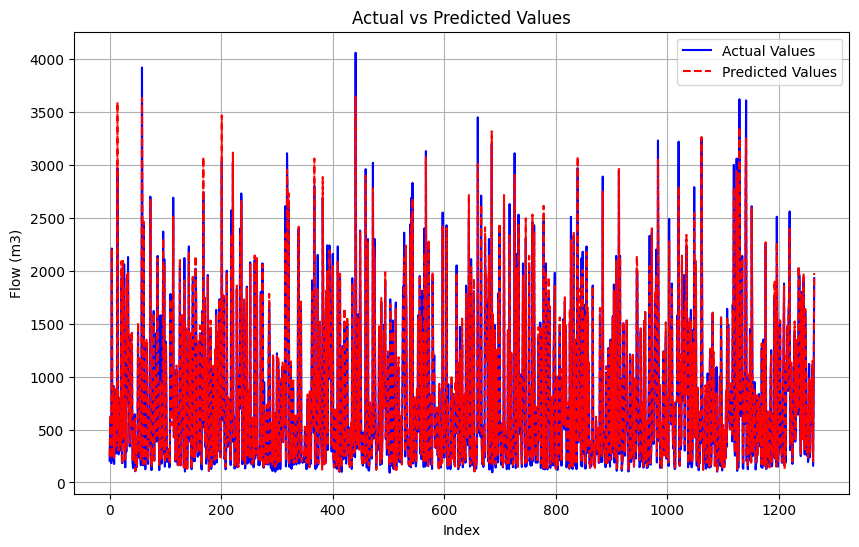

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_test)), Y_test, color='blue', label='Actual Values')
plt.plot(range(len(Y_pred)), Y_pred, color='red', linestyle='--', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Flow (m3/s)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

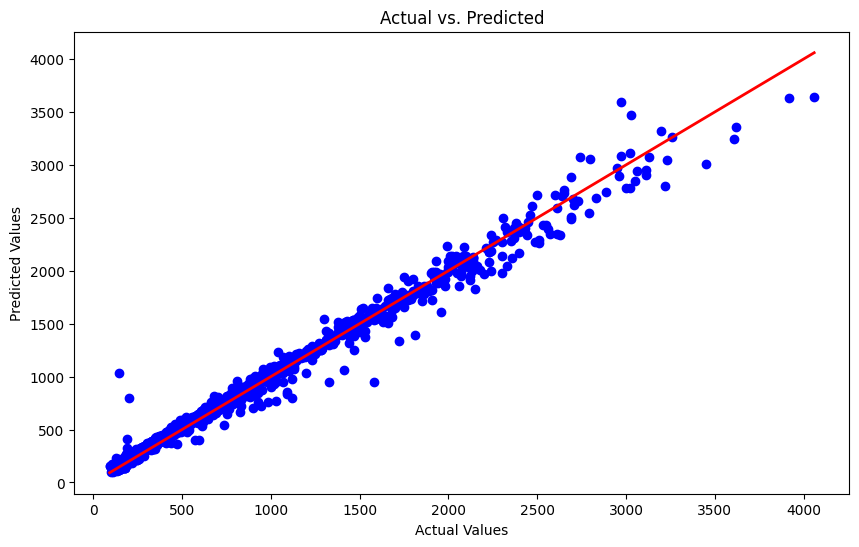

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

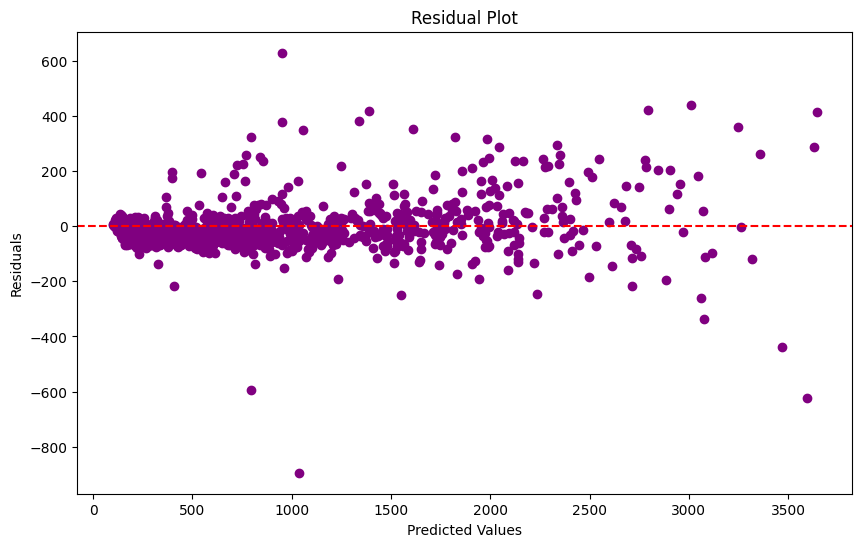

In [56]:
residuals = Y_test - Y_pred

plt.figure(figsize=(10, 6))
plt.scatter(Y_pred, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

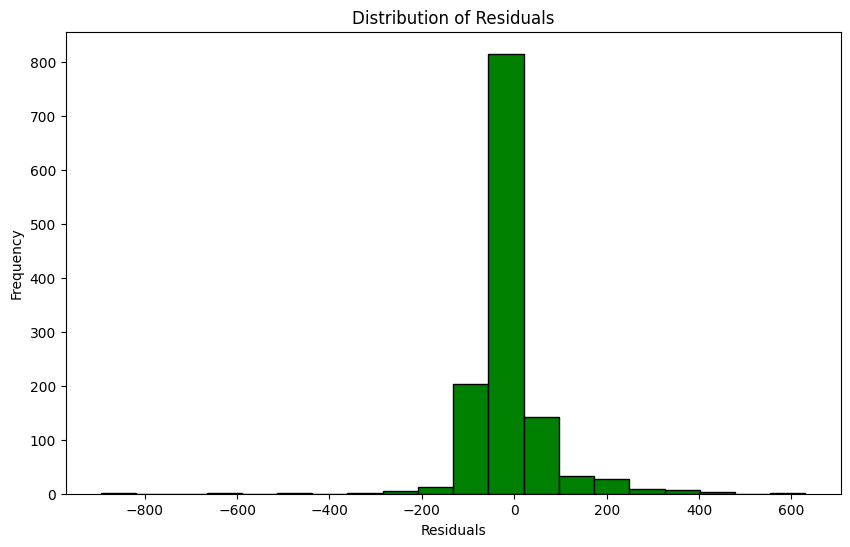

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='green', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()